In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_recall_curve

# Descriptive Analysis

In [2]:
# Load the data
credit_df = pd.read_csv('credit_risk_dataset.csv')
credit_df.info(), credit_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


(None,
    person_age  person_income person_home_ownership  person_emp_length  \
 0          22          59000                  RENT              123.0   
 1          21           9600                   OWN                5.0   
 2          25           9600              MORTGAGE                1.0   
 3          23          65500                  RENT                4.0   
 4          24          54400                  RENT                8.0   
 
   loan_intent loan_grade  loan_amnt  loan_int_rate  loan_status  \
 0    PERSONAL          D      35000          16.02            1   
 1   EDUCATION          B       1000          11.14            0   
 2     MEDICAL          C       5500          12.87            1   
 3     MEDICAL          C      35000          15.23            1   
 4     MEDICAL          C      35000          14.27            1   
 
    loan_percent_income cb_person_default_on_file  cb_person_cred_hist_length  
 0                 0.59                         Y        

In [3]:
# Turn loan_percent_income into a percentage
credit_df['loan_percent_income'] = credit_df['loan_percent_income'] * 100

# Look at descriptive stats of data
credit_df.describe()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length
count,32581.000000,3.258100e+04,31686.000000,32581.000000,29465.000000,32581.000000,32581.000000,32581.000000
mean,27.734600,6.607485e+04,4.789686,9589.371106,11.011695,0.218164,17.020349,5.804211
std,6.348078,6.198312e+04,4.142630,6322.086646,3.240459,0.413006,10.678176,4.055001
min,20.000000,4.000000e+03,0.000000,500.000000,5.420000,0.000000,0.000000,2.000000
25%,23.000000,3.850000e+04,2.000000,5000.000000,7.900000,0.000000,9.000000,3.000000
50%,26.000000,5.500000e+04,4.000000,8000.000000,10.990000,0.000000,15.000000,4.000000
75%,30.000000,7.920000e+04,7.000000,12200.000000,13.470000,0.000000,23.000000,8.000000
max,144.000000,6.000000e+06,123.000000,35000.000000,23.220000,1.000000,83.000000,30.000000


There seems to be severe outliers in `person_age`, `person_income`, and `person_emp_length` so we will remove these observations.

In [4]:
credit_df = credit_df[credit_df['person_age'] <= 100] # People 100 years old and younger
credit_df = credit_df[credit_df['person_emp_length'] <= 70] # Employment length of 70 years or less
credit_df = credit_df[credit_df['person_income'] <= 1e+06] # Income of $1,000,000 and below

## Distribution of Categorical Variables

In [5]:
# Categorical Variables
cat_vars = ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']

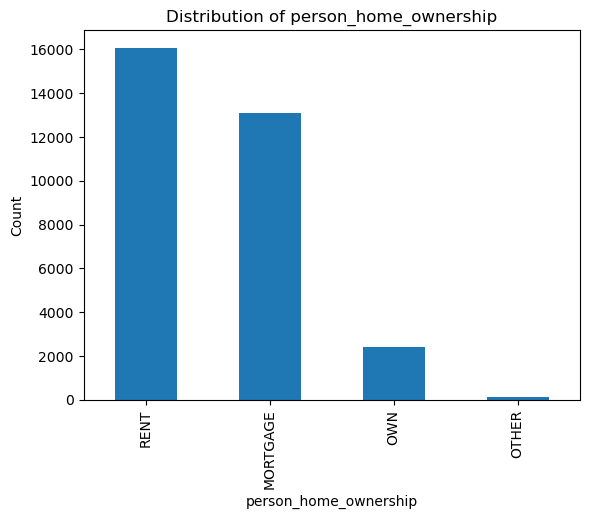

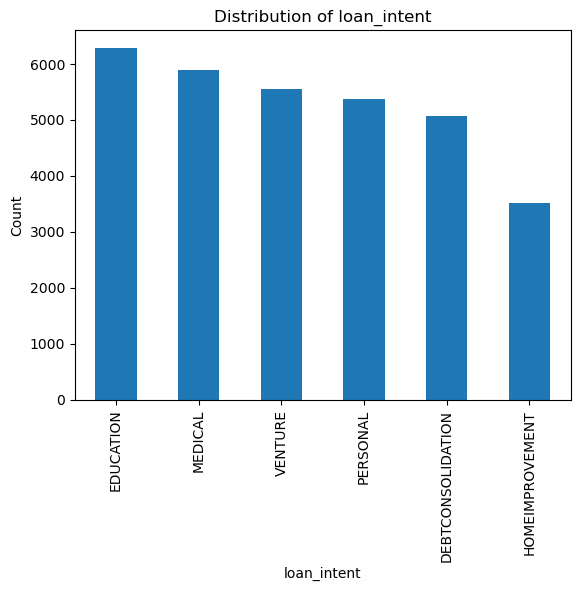

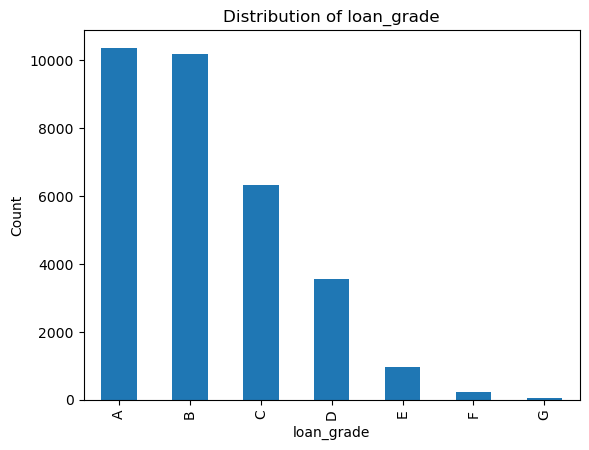

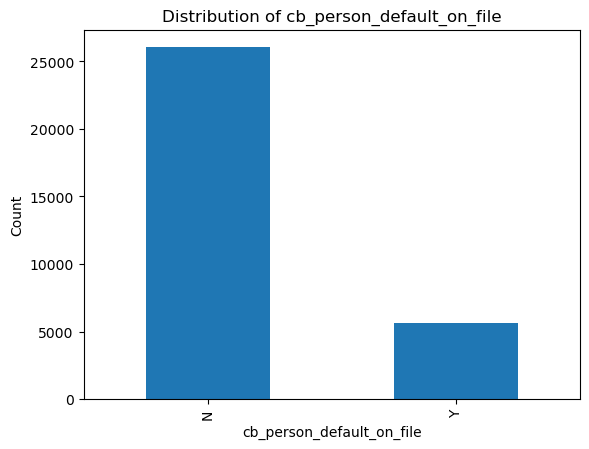

In [6]:
# Bar plot for categorical variables
for col in cat_vars:
    plt.figure()
    credit_df[col].value_counts().plot(kind='bar')
    plt.title(f'Distribution of {col}')
    plt.ylabel(f'Count')
    plt.show()

I will encode the categorical variables so that they can be handled by the models.

In [7]:
# Copy dataset
data = credit_df.copy()

# One hot encode categorical variables
one_hot_cols = ['loan_intent', 'person_home_ownership', 'cb_person_default_on_file', 'loan_grade']
data = pd.get_dummies(data, columns=one_hot_cols, drop_first=True) # drop_first=True for logistic mdoel

In [8]:
data.info() # All variables are numerical/bool values

<class 'pandas.core.frame.DataFrame'>
Index: 31671 entries, 1 to 32580
Data columns (total 23 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   person_age                   31671 non-null  int64  
 1   person_income                31671 non-null  int64  
 2   person_emp_length            31671 non-null  float64
 3   loan_amnt                    31671 non-null  int64  
 4   loan_int_rate                28626 non-null  float64
 5   loan_status                  31671 non-null  int64  
 6   loan_percent_income          31671 non-null  float64
 7   cb_person_cred_hist_length   31671 non-null  int64  
 8   loan_intent_EDUCATION        31671 non-null  bool   
 9   loan_intent_HOMEIMPROVEMENT  31671 non-null  bool   
 10  loan_intent_MEDICAL          31671 non-null  bool   
 11  loan_intent_PERSONAL         31671 non-null  bool   
 12  loan_intent_VENTURE          31671 non-null  bool   
 13  person_home_ownership

## Distribution of Numerical Variables

In [9]:
# % of observations where loan_status = 1
(data['loan_status'] == 1).sum() / data['loan_status'].count()

0.21549682675002368

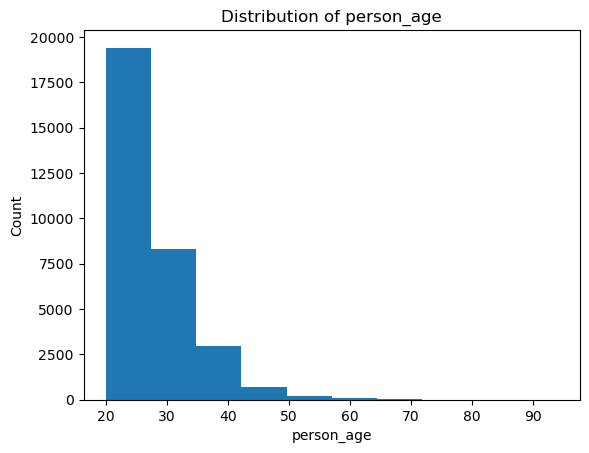

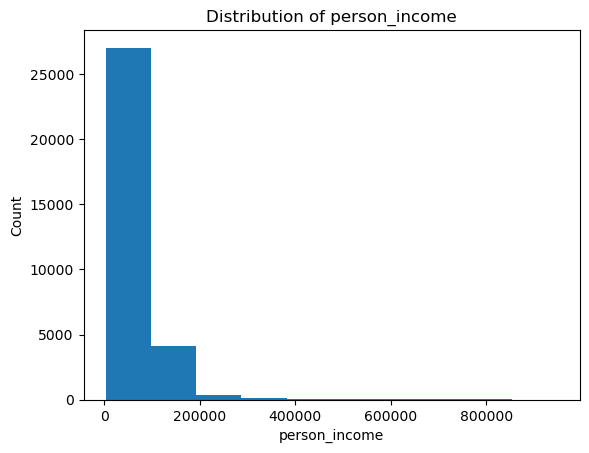

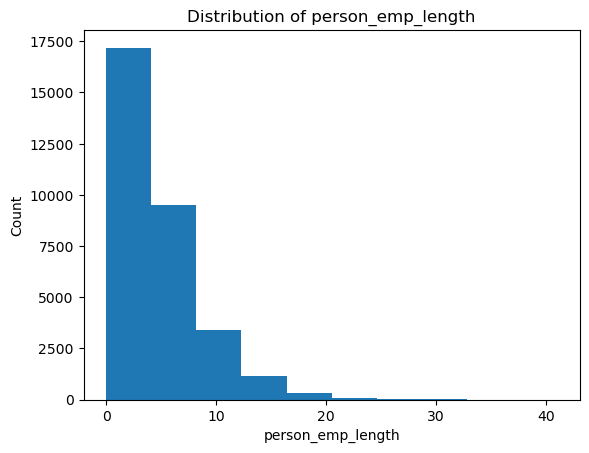

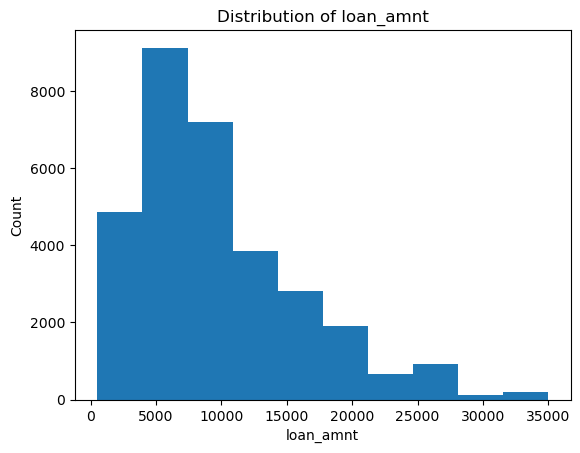

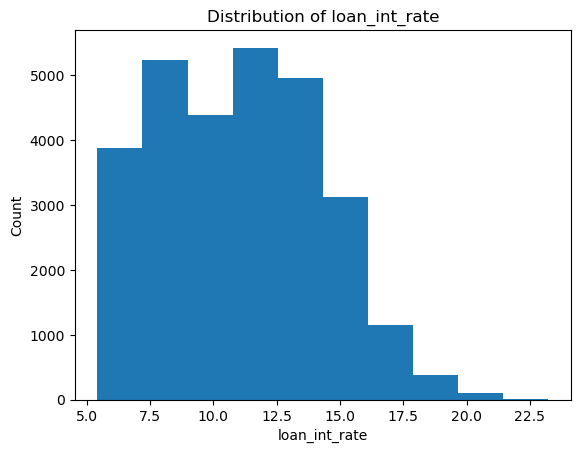

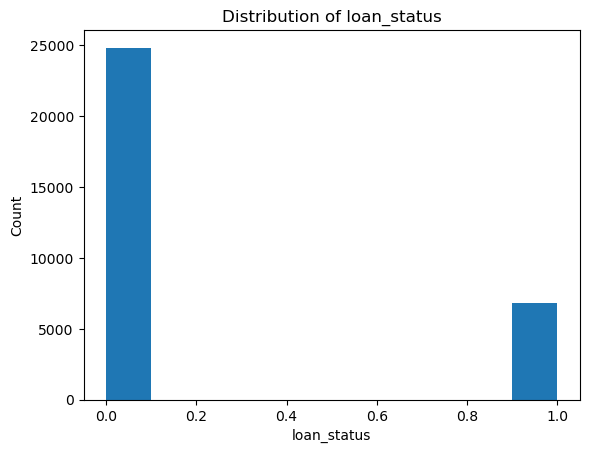

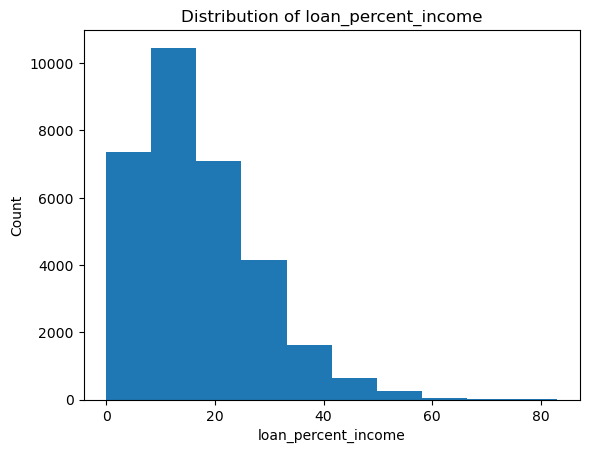

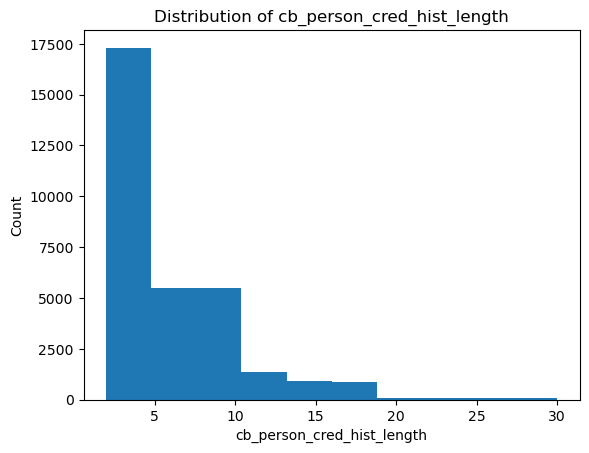

In [10]:
# Numerical columns
num_cols = ['person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate', 
            'loan_status', 'loan_percent_income', 'cb_person_cred_hist_length']

for col in num_cols:
    plt.figure()
    plt.hist(data[col])
    plt.title(f'Distribution of {col}')
    plt.xlabel(f'{col}')
    plt.ylabel('Count')
    plt.show()

## Missing Values

In [11]:
data.isnull().sum()

person_age                        0
person_income                     0
person_emp_length                 0
loan_amnt                         0
loan_int_rate                  3045
loan_status                       0
loan_percent_income               0
cb_person_cred_hist_length        0
loan_intent_EDUCATION             0
loan_intent_HOMEIMPROVEMENT       0
loan_intent_MEDICAL               0
loan_intent_PERSONAL              0
loan_intent_VENTURE               0
person_home_ownership_OTHER       0
person_home_ownership_OWN         0
person_home_ownership_RENT        0
cb_person_default_on_file_Y       0
loan_grade_B                      0
loan_grade_C                      0
loan_grade_D                      0
loan_grade_E                      0
loan_grade_F                      0
loan_grade_G                      0
dtype: int64

We can see that `loan_int_rate` has missing values. To solve this problem I will impute the median values.

In [12]:
# impute median values
data['loan_int_rate'] = data['loan_int_rate'].fillna(data['loan_int_rate'].median())

In [13]:
# Recheck for missing values
data.isnull().sum()

person_age                     0
person_income                  0
person_emp_length              0
loan_amnt                      0
loan_int_rate                  0
loan_status                    0
loan_percent_income            0
cb_person_cred_hist_length     0
loan_intent_EDUCATION          0
loan_intent_HOMEIMPROVEMENT    0
loan_intent_MEDICAL            0
loan_intent_PERSONAL           0
loan_intent_VENTURE            0
person_home_ownership_OTHER    0
person_home_ownership_OWN      0
person_home_ownership_RENT     0
cb_person_default_on_file_Y    0
loan_grade_B                   0
loan_grade_C                   0
loan_grade_D                   0
loan_grade_E                   0
loan_grade_F                   0
loan_grade_G                   0
dtype: int64

Missing values have been imputed.

## Correlation Matrix

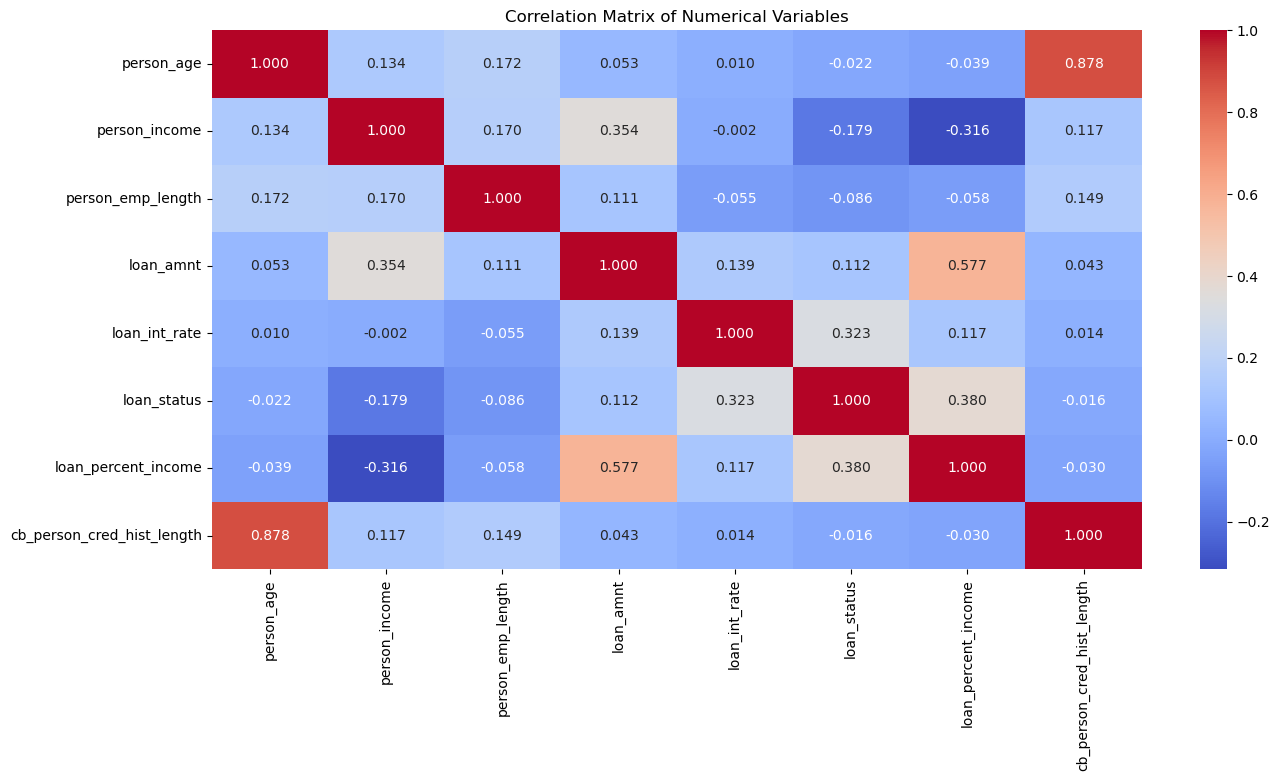

In [14]:
plt.figure(figsize=(15, 7))
sns.heatmap(data[num_cols].corr(), annot=True, cmap='coolwarm', cbar=True, fmt=".3f")
plt.title('Correlation Matrix of Numerical Variables')
plt.show()

Variables exhibiting high correlation are `log_person_age` and `cb_person_cred_hist_length`, `loan_amnt` and `loan_percent_income`, and `loan_status` with `loan_percent_income` and `loan_interest_rate`.

# Model Building

## Logit Regression Model

The first model will be a logistic regression model. I will then compare this model to a basic decision tree model and a cost complexity pruned decision tree to see which one better predicts credit default.

In [15]:
# Remove the dependent variable
num_cols.remove('loan_status')

Optimization terminated successfully.
         Current function value: 0.333828
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:            loan_status   No. Observations:                25336
Model:                          Logit   Df Residuals:                    25313
Method:                           MLE   Df Model:                           22
Date:                Mon, 08 Sep 2025   Pseudo R-squ.:                  0.3571
Time:                        18:20:46   Log-Likelihood:                -8457.9
converged:                       True   LL-Null:                       -13156.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                          -2.3622      0.080    -29.558      0.000   

<function matplotlib.pyplot.show(close=None, block=None)>

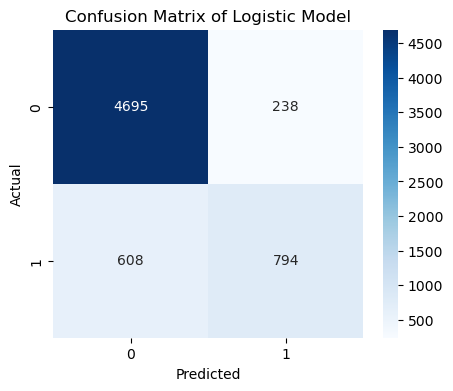

In [16]:
X = data.drop(columns='loan_status') # Independent Variables
y = data['loan_status'] # Dependent Variable (0 = No Default, 1 = Default)

X=X.astype(int) # Make sure all variables are numeric

# Standardize numeric columns
scaler = StandardScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])

# Add intercept term
X = sm.add_constant(X)

# Split 80% of data into training and 20% into testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=425)

# Fit logistic model
logit_model = sm.Logit(y_train, X_train)
result = logit_model.fit()

# Print Results
print(result.summary())

# Make predictions
y_pred_prob = result.predict(X_test)  # Probabilities
y_pred_logit = (y_pred_prob >= 0.5).astype(int)  # Convert to binary predictions

# Evaluate performance
accuracy = accuracy_score(y_test, y_pred_logit)
error_rate = 1 - accuracy

print(f"\nFinal Accuracy: {accuracy:.4f}") # Print accuracy
print(f"Error Rate: {error_rate:.4f}")  # Print the error rate
print("\nClassification Report Logistic:\n", classification_report(y_test, y_pred_logit))

# Confusion Matrix
plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix(y_test, y_pred_logit), annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix of Logistic Model")
plt.show

This logit model seems to do an ok job at predicting credit default, with an accuracy of 86.65%. It performs significantly better at predicting "safe" loans than "risky" loans. When predicting a safe loan, it is correct 89% of the time and correctly predicts 95% of safe loans. However, when predicting loans that will default, it is correct 77% percent of the time and only predicts 57% of actual loan defaults.


## Basic Decision Tree Model

In [17]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import roc_auc_score

Final Accuracy: 0.8882
Error Rate: 0.1118

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.92      0.93      4933
           1       0.74      0.77      0.75      1402

    accuracy                           0.89      6335
   macro avg       0.83      0.85      0.84      6335
weighted avg       0.89      0.89      0.89      6335

Node Count: 4543


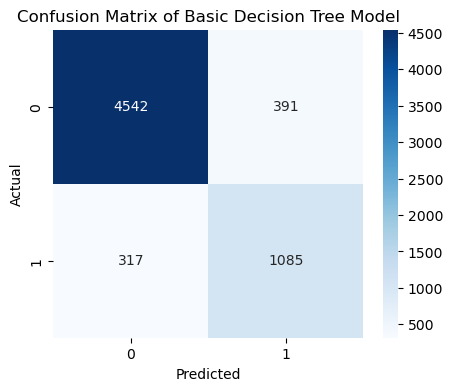

In [18]:
# Train basic decision tree model
dt_model = DecisionTreeClassifier(criterion='gini', random_state=425)
dt_model.fit(X_train, y_train)

# Predictions
y_pred_dt = dt_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_dt)
print(f"Final Accuracy: {accuracy:.4f}")
print(f'Error Rate: {1-accuracy:.4f}')
print("\nClassification Report:\n", classification_report(y_test, y_pred_dt))

# Confusion Matrix
plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix(y_test, y_pred_dt), annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix of Basic Decision Tree Model")
plt.show

# Node count for the basic decision tree
print(f'Node Count: {dt_model.tree_.node_count}')

The basic decision tree improves on the logistic model in certain categories, with a better overall performance. First, it has a higher accuracy of 88.79%. When predicting safe loans, this model is correct 93% of the time and predicted 92% of all safe loans. It also has an f1-score of 0.93 when predicting no default. Like the logistic model, the basic decision tree model has a lower precision when predicting a loan will default than when predicting a loan is safe. When predicting a loan will default, it is correct 74% of the time. There is significant improvement in recall when predicting a loan will default, going from 57% in the previous model to 76% in this model. The f1-score when predicting a loan will default is 0.75. The node count for this decision tree is 4,553.



## Cost Complexity Pruned Decision Tree Model

Optimal alpha: 0.00025
Final Accuracy: 0.9271
Error Rate: 0.0729

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.99      0.95      4933
           1       0.97      0.69      0.81      1402

    accuracy                           0.93      6335
   macro avg       0.94      0.84      0.88      6335
weighted avg       0.93      0.93      0.92      6335

Node Count: 137


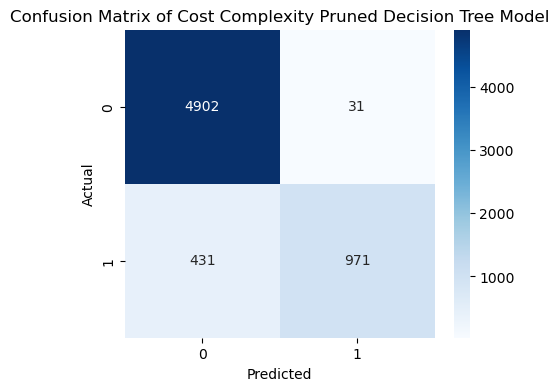

In [19]:
# Train full grown decision tree
full_tree = DecisionTreeClassifier(criterion='gini', random_state=425)
full_tree.fit(X_train, y_train)

# Cost complexity pruning path
path = full_tree.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas

# Train trees for each alpha value
trees = [DecisionTreeClassifier(criterion="gini", random_state=425, ccp_alpha=alpha).fit(X_train, y_train) for alpha in ccp_alphas]

# Cross validate to fine best alpha
alpha_scores = [
    np.mean(cross_val_score(tree, X_train, y_train, scoring="accuracy", cv=2)) # cv=2 because any cv>2 took too long to run
    for tree in trees
]

# Find the best alpha
best_alpha = ccp_alphas[np.argmax(alpha_scores)]
print(f"Optimal alpha: {best_alpha:.5f}")

# Train the Final Pruned Tree
pruned_tree = DecisionTreeClassifier(criterion="gini", random_state=425, ccp_alpha=best_alpha)
pruned_tree.fit(X_train, y_train)

# Evaluate the Final Model
y_pred_pruned_dt = pruned_tree.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_pruned_dt)
print(f"Final Accuracy: {accuracy:.4f}")
print(f'Error Rate: {1-accuracy:.4f}')
print("\nClassification Report:\n", classification_report(y_test, y_pred_pruned_dt))

# Confusion Matrix
plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix(y_test, y_pred_pruned_dt), annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix of Cost Complexity Pruned Decision Tree Model")
plt.show

# Node count for the pruned decision tree
print(f'Node Count: {pruned_tree.tree_.node_count}')

This decision tree model with cost complexity pruning further improves on the basic decision tree model. The optimal alpha is determined to be 0.00025, and it has an accuracy of 92.71%. When predicting a loan is safe it is correct 92% of the time and predicts 99% of all safe loans with an f1-score of 0.95. When predicting a loan will default, this model is correct 97% of the time but only predicts 69% of all the defaulted loans which is less than the basic decision tree. The corresponding f1-score is 0.81. The node count of this decision tree has been pruned to 137.
